## Experimentation with GravNet_Conv

In [54]:
import torch_geometric
import torch
import os
import tarfile
import random

from gnn_tracking.metrics.losses import (
    PotentialLoss,
    BackgroundLoss,
)

### 1. Obtain data for training

In [55]:
raw_data_dir = "../raw_data"
output_dir = "../data"

In [108]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [109]:
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".tar.gz"):
        tar_gz_path = os.path.join(raw_data_dir, filename)
        tar = tarfile.open(tar_gz_path, "r:gz")
        tar.extractall(output_dir)
        tar.close()

In [110]:
raw_data = []

for foldername in os.listdir(output_dir):
    folder = os.path.join(output_dir, foldername)
    for filename in os.listdir(folder):
        if filename.endswith(".pt"):
            file = os.path.join(folder, filename)
            raw_data.append(torch.load(file).to(device))

random.shuffle(raw_data)

### 2. Observe point cloud properties

In [111]:
print("Length of dataset:", len(raw_data))
print("Dimensions of sample point cloud", raw_data[0].x.size())
print("Dimensions of sample IDs", raw_data[0].particle_id.size())
print("Unique ID Values", torch.unique(raw_data[0].particle_id).size())

Length of dataset: 900
Dimensions of sample point cloud torch.Size([8554, 7])
Dimensions of sample IDs torch.Size([8554])
Unique ID Values torch.Size([1300])


### 3. Loss function initializatinon

In [1158]:
# Measures average ratio between intra and inter cluster hit distances

def accuracy(x, id, n=50):
    mean_distance = 0
    cluster_distance = 0
    for i in range(n):
        rb = random.randint(0, len(id) - 1)
        ra = random.randint(0, len(id) - 1)
        ri = random.randint(0, len(id) - 1)

        masked_x = x[id == id[ri]]
        rbd = random.randint(0, len(masked_x) - 1)
        rad = random.randint(0, len(masked_x) - 1)
        mean_distance += torch.sqrt(((x[ra] - x[rb])**2).sum())
        cluster_distance += torch.sqrt(((masked_x[rbd] - masked_x[rad])**2).sum())
    
    return (cluster_distance/mean_distance).item()


In [1159]:
p_loss = PotentialLoss(q_min=0.01, radius_threshold=10.0, attr_pt_thld=0.9)
b_loss = BackgroundLoss(sb=1)

def loss_function(x, beta, p_cloud, background_weight=0.05):
    full_mask = torch.ones_like(p_cloud.particle_id).bool()
    p_l = p_loss.forward(beta=beta, x=x, particle_id=p_cloud.particle_id, reconstructable=p_cloud.reconstructable, track_params=full_mask, ec_hit_mask=full_mask)
    b_l = b_loss.forward(beta=beta, particle_id=p_cloud.particle_id, ec_hit_mask=full_mask)

    return 500*p_l['attractive'] + 5*p_l['repulsive'] + background_weight*b_l

#### 4. Training Loop

In [1395]:
class Model(torch.nn.Module):
    def __init__(self, embed_dim, map_dim, intermediate_dim, k, num_layers=4):
        super(Model, self).__init__()
        self.initial_layer = torch.nn.Linear(7, embed_dim)
        self.gravnets = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.gravnets.append(torch_geometric.nn.conv.GravNetConv(in_channels=embed_dim, out_channels=embed_dim, space_dimensions=map_dim, propagate_dimensions=intermediate_dim, k=k))
        self.final_layer = torch.nn.Linear(num_layers * embed_dim, embed_dim*3)
        self.final_layer = torch.nn.Linear(num_layers*embed_dim, 3)

        self.activation = torch.nn.LeakyReLU()
        self.normalizing_factor = None
        self.embed_dim = embed_dim

    def forward(self, x):
        x = self.initial_layer(x)
        list = []
        for i in range(len(self.gravnets)):
            x = self.gravnets[i](self.activation(x))
            list.append(x)
        x = self.final_layer(self.activation(torch.cat(list, dim=-1)))

        if self.normalizing_factor == None:
            self.normalizing_factor = torch.abs(x).mean().item()
        
        y = x/self.normalizing_factor

        return y[:, 1:], torch.sigmoid(y[:, 0])

gravnet = Model(embed_dim=8, map_dim=3, intermediate_dim=16, k=12, num_layers=1).to(device)

In [1403]:
lr = 0.06

optimizer = torch.optim.Adam(gravnet.parameters(), lr=lr) # 0.03 -> 0.01 -> 0.0025
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 1)

In [1404]:
data_index = 0
loss_storage = []
iteration = 0
smoothed_loss = 1

In [ ]:
while True:
    iteration += 1
    optimizer.zero_grad()
    x, beta = gravnet(raw_data[data_index].x)
    loss = loss_function(x, beta, raw_data[data_index])
    
    smoothed_loss = smoothed_loss*0.95 + loss.item()*0.05
    print("Iteration:", iteration, lr, "Total Loss: ", loss.item(), accuracy(x, raw_data[data_index].particle_id))
    loss_storage.append(smoothed_loss)

    loss.backward()
    optimizer.step()
    scheduler.step()
    data_index += 1

    if iteration % 150 == 0 and lr > 0.001:
        lr = lr/3
        optimizer = torch.optim.Adam(gravnet.parameters(), lr=lr)

    if(data_index >= (len(raw_data) - 100)):
        data_index = 0

# Cleared training output due to length

### 5. Evaluation

In [ ]:
import numpy as np

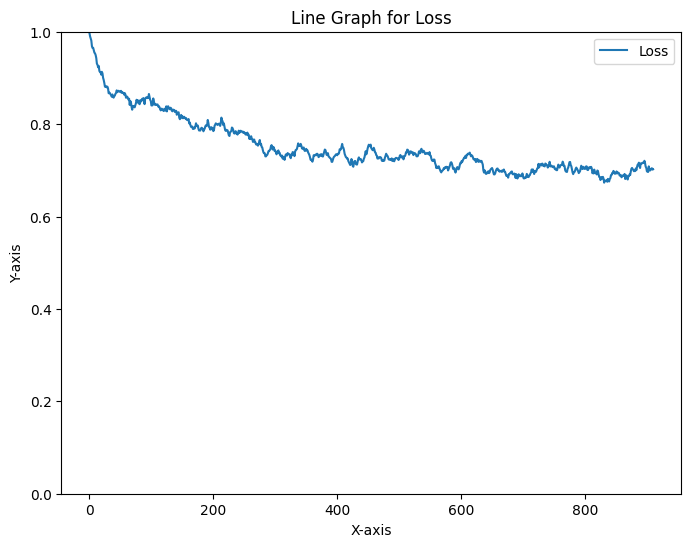

In [1315]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.lineplot(x=range(len(loss_storage)), y=loss_storage, label="Loss")

plt.title('Line Graph for Loss')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.gca().set_ylim(0, 1)

plt.legend()
plt.show()

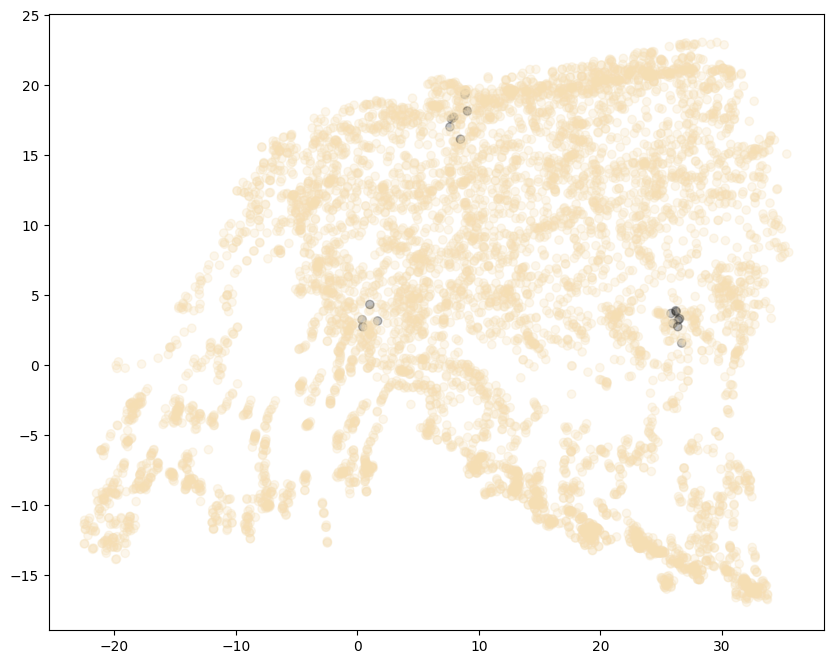

In [1410]:
# View three random particle's hits in the generated latent space (from test set)

y, _ = gravnet(raw_data[850].x)
POS = y.detach()
ID = raw_data[850].particle_id

id_np = ID.to('cpu').numpy()
pos_np = POS.to('cpu').numpy()

unique_ids = np.unique(id_np)
highlight_id = np.random.choice(unique_ids)
highlight_id_2 = np.random.choice(unique_ids)
highlight_id_3 = np.random.choice(unique_ids)

colors = ['black' if (id == highlight_id or id == highlight_id_2 or id == highlight_id_3) else 'wheat' for id in id_np]

plt.figure(figsize=(10, 8))
plt.scatter(pos_np[:, 0], pos_np[:, 1], color=colors, alpha=0.25)
plt.show()